In [73]:
import os
from os import path
import sys
sys.path.append('..')

import numpy as np
import pandas as pd

import collections

import utils

# import logging as log
# log.basicConfig(level=log.DEBUG)

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

from datetime import datetime, timedelta

In [74]:
DATA_FOLDER = path.join('..', 'data')
RESULTS_FOLDER = path.join('..', 'results')

STATES = ['AC', 'AL', 'AM', 'AP', 'BA', 'CE',
         'DF', 'ES', 'GO', 'MA', 'MT', 'MS',
         'MG', 'PA', 'PB', 'PR', 'PE', 'PI',
         'RJ', 'RN', 'RO', 'RS', 'RR', 'SC',
         'SE', 'SP', 'TO']

MODELS = ['linear-regression', 'gaussian-process', 'mlp', 'svr', 'exponential-holt']

STRATEGIES = [
    'aggregated',
    'windowed'
]

METRICS = ['MAE', 'RMSE', 'MSLE']

In [75]:
state='CE'
FONTSIZE=18
TO_DROP = 20

df_state = utils.download_state(state=state)
df_state = df_state[df_state['cases'] != 0]
dayone = df_state.index[0]
dayout = datetime.strptime(df_state.index[-1], '%d/%m/%Y')  
days = np.array(utils.count_days(dayone=dayone, dayout=dayout, date_string='%d/%m/%Y'))
X_full = days.reshape(-1,1)
y_full = utils.get_labels(df_state['cases']).reshape(-1,1)
X_full, y_full = utils.check_inputs(X_full, y_full)

In [76]:
state='CE'
FONTSIZE=18
TO_DROP = 10

df_state = utils.download_state(state=state)
df_state = df_state[df_state['cases'] != 0]
df_state = df_state.iloc[:-TO_DROP]
dayone = df_state.index[0]
dayout = datetime.strptime(df_state.index[-1], '%d/%m/%Y')  
days = np.array(utils.count_days(dayone=dayone, dayout=dayout, date_string='%d/%m/%Y'))
X = days.reshape(-1,1)
y = utils.get_labels(df_state['cases']).reshape(-1,1)
X, y = utils.check_inputs(X, y)

In [77]:
VAR_FUTURE=14

from statsmodels.tsa.api import Holt

model_holt = Holt(utils.ajust_df(df_state), exponential=True).fit(smoothing_level=0.5, smoothing_slope=0.01, optimized=False)
forecast = model_holt.forecast(VAR_FUTURE)
X_pred = np.array(forecast.index.tolist())

last_value = df_state.cases.iloc[-1]
forecast = utils.rescale_yhat(forecast.values, last_value)

#
model_holt = Holt(utils.ajust_df(df_state), exponential=True).fit(smoothing_level=0.5, smoothing_slope=0.01, optimized=False)
forecast = model_holt.forecast(VAR_FUTURE)
X_pred = np.array(forecast.index.tolist())

last_value = df_state.cases.iloc[-1]
forecast = utils.rescale_yhat(forecast.values, last_value)

#
model_holt = Holt(utils.ajust_df(df_state.iloc[-7:]), exponential=True).fit(smoothing_level=0.5, smoothing_slope=0.01, optimized=False)
forecast_last_7 = model_holt.forecast(VAR_FUTURE)

last_value = df_state.iloc[-7:].cases.iloc[-1]
forecast_last_7 = utils.rescale_yhat(forecast_last_7.values, last_value, force=True, factor=4.2)


In [78]:
from sklearn.linear_model import LinearRegression

model_lin = LinearRegression()

In [79]:
model_lin.fit(X, y)

df_out = utils.forecast(model_lin, future=VAR_FUTURE, dayone=dayone, date_string='%d/%m/%Y', 
                                        dayout=dayout, date_string_output='%d/%m/%Y')

last_value = df_state.cases.iloc[-1]
df_out['yhat'] = utils.rescale_yhat(df_out['yhat'].values, last_value)

In [80]:
df_state_last_7 = df_state.iloc[-7:]
dayone = df_state_last_7.index[0]
dayout = datetime.strptime(df_state_last_7.index[-1], '%d/%m/%Y')  
days = np.array(utils.count_days(dayone=dayone, dayout=dayout, date_string='%d/%m/%Y'))
X_last_7 = days.reshape(-1,1)
y_last_7 = utils.get_labels(df_state_last_7['cases']).reshape(-1,1)
X_last_7, y_last_7 = utils.check_inputs(X_last_7, y_last_7)

In [81]:
model_lin.fit(X_last_7, y_last_7)

df_out_last_7 = utils.forecast(model_lin, future=VAR_FUTURE, dayone=dayone, date_string='%d/%m/%Y', 
                                        dayout=dayout, date_string_output='%d/%m/%Y')

last_value = df_state_last_7.cases.iloc[-1]
df_out_last_7['yhat'] = utils.rescale_yhat(df_out_last_7['yhat'].values, last_value)

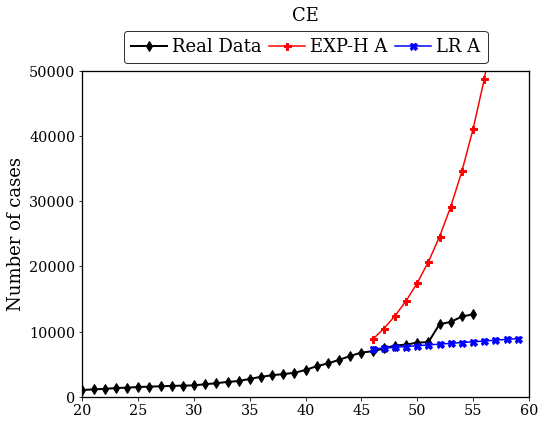

In [92]:
state='CE'
FONTSIZE=18

%matplotlib inline


plt.rc('font', family='serif')
plt.rc('xtick', labelsize='x-large')
plt.rc('xtick', labelsize='x-large')
plt.rc('ytick', labelsize='x-large')


fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1)

## Prepare data

# X_pred = np.array(forecast.index.tolist())
y_full_holt = forecast
y_last_7_holt = forecast_last_7
y_full_lin = df_out.yhat.values
y_last_7_lin = df_out_last_7.yhat.values

#

ax.plot(X_full, y_full, 'black', linewidth=2, marker='d', markersize=7, label='Real Data')
ax.plot(X_pred, y_full_holt, c='r', marker='P', markersize=7, label='EXP-H A')
# ax.plot(X_pred, y_last_7_holt, c='green', marker='X', markersize=7, label='EXP-H W')
ax.plot(X_pred, y_full_lin[1:], c='blue', marker='X', markersize=7, label='LR A')
# ax.plot(X_pred, y_last_7_lin[1:], c='yellow', marker='P', markersize=7, label='LR W')

leg = ax.legend(fontsize=FONTSIZE, bbox_to_anchor=(0.5, 1.15), loc='upper center', ncol=4, handletextpad=0.3, columnspacing=0.4)

leg.get_frame().set_edgecolor('k')


ax.set_ylabel('Number of cases', fontsize=FONTSIZE)
# ax.set_xlabel('Time (days)', fontsize=FONTSIZE)
# plt.grid(ls='-.')

for ori in ax.spines:
    ax.spines[ori].set_linewidth(1.3)
    

# plt.ylim(2410, 2430)
plt.ylim(0, 50000)
plt.xlim(20, 60)

plt.title(f'{state}', pad=50, fontsize=FONTSIZE)

# plt.yscale('log')

# ax.grid(which='major', linestyle='-.')

# plt.savefig(path.join(RESULTS_FOLDER, 'figures', '{}-comparativo.png'.format(state)), dpi=300, bbox_inches='tight')

plt.show()

In [83]:
y_last_7_holt

array([12664.92205426, 13564.1321981 , 14567.92208321, 15688.45451975,
       16939.30687437, 18335.63558565, 19894.35981297, 21634.36644409,
       23576.73894543, 25745.01282812, 28165.46082515, 30867.41123516,
       33883.60329013, 37250.58385307])

In [84]:
y_full_lin

array([7216.41111111, 7338.20096618, 7459.99082126, 7581.78067633,
       7703.5705314 , 7825.36038647, 7947.15024155, 8068.94009662,
       8190.72995169, 8312.51980676, 8434.30966184, 8556.09951691,
       8677.88937198, 8799.67922705, 8921.46908213])